## Analisis de errores: Parametros de elementos ideales

**Autor**: Jesús del Hoyo

**Fecha**:   29/10/2018

**Objetivo**: Ecograb project, polariscope callibration

**Explicación**:

En este pequeño archivo, voy a intentar comprobar cómo afectan los parámetros de los dos elementos ideales básicos: diatenuador y retardaror, a la matriz de Mueller. Para ello, simularé errores gaussianos de amplitud variable y repetiré el "experimento" muchas veces con diferentes ángulos para después promediar. El resto de parámetros se dejarán en valores próximos a los reales en nuestro polarímetro.

El error en la matriz de Mueller lo definiré como la norma de Frobenius de la resta de matrices (en la literatura usan a veces la norma infinita (maximo módulo de los vectores columna) o la norma 2 (maximo modulo Mx con x unitario)).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib widget

In [2]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat

from polarimeter.utils import plot_2d, generate_even_distribution
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting
from matplotlib.colors import LogNorm
from matplotlib import ticker, colors


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import polarimeter.polarimeter as opsys
import numpy as np
import os

C:\Users\Jesus\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Diatenuador

Comenzamos con el diatenuador. Aquí hay que testear cuatro parámetros: ángulo, p1, p2 y elipticidad. Los valores por defecto serán: p1 = 0.95, p2 = 0.1, chi = 0.

**Ángulo**

En este caso no voy a promediar con diferentes ángulos. El resultado es un plot 2D con amplitud de error y ángulo como ejes x e y.

In [93]:
# Espacio de medida
tic = time.time()
Nerrores = 50
Nangulos = 50
Naverage = 200
max_angulo = 180
max_error = 5
# Otros parametros
p1 = 0.95
p2 = 0.1
chi = 0
# Crear variables
fi = np.linspace(0,max_angulo,Nangulos)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Nangulos])

# Bucle principal
for indA, angulo in enumerate(fi):
    M = ps.general_diattenuator_parvect(p1, p2, angulo*degrees, chi, carac=False)
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            angulo_final = (angulo + noise)*degrees
            M_con_error = ps.general_diattenuator_parvect(p1, p2, angulo_final, chi, carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indA] = 1e-10
        else:
            errores[indE, indA] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

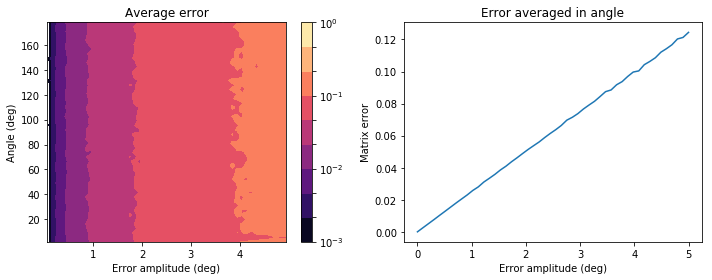

In [94]:
# Parameters
LowThres = 1e-3
HighThres = 1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_angulo]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Angle (deg)")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = np.mean(errores, axis = 1)
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Matrix error")
plt.title("Error averaged in angle")

plt.tight_layout()



**p1**

El resultado es un plot 2D con amplitud de error y ángulo como ejes x e y.

In [117]:
tic = time.time()
# Espacio de medida
Nerrores = 50
Np1 = 50
Naverage = 200
max_angulo = 180
max_error = 0.1
max_p1 = 1
# Otros parametros
p2 = 0.1
chi = 0
# Crear variables
p1_array = np.linspace(0,max_p1,Np1)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Np1])

# Bucle principal
for indP, p1 in enumerate(p1_array):
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            # Crear matriz con angulo aleatorio            
            angulo = np.random.rand(1) * max_angulo * degrees
            M = ps.general_diattenuator_parvect(p1, p2, angulo, chi, carac=False)
            # Crear la matriz con error
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            p1_error = (p1 + noise)
            M_con_error = ps.general_diattenuator_parvect(p1_error[0], p2, angulo, chi, carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indP] = 1e-10
        else:
            errores[indE, indP] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

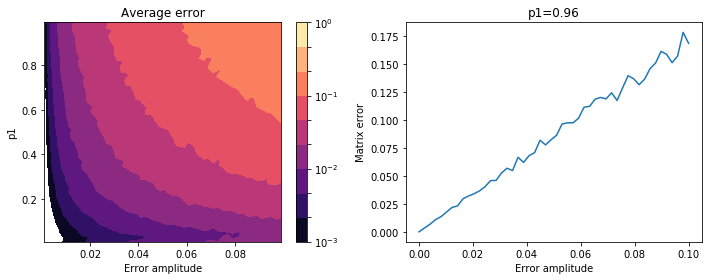

In [118]:
# Parameters
LowThres = 1e-3
HighThres = 1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_p1]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude")
plt.ylabel("p1")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = errores[:,-3]
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude")
plt.ylabel("Matrix error")
plt.title("p1=0.96")

plt.tight_layout()



**p2**

El resultado es un plot 2D con amplitud de error y p2 como ejes x e y.

In [120]:
tic = time.time()
# Espacio de medida
Nerrores = 50
Np2 = 50
Naverage = 200
max_angulo = 180
max_error = 0.1
max_p2 = 1
# Otros parametros
p1 = 0.95
chi = 0
# Crear variables
p2_array = np.linspace(0,max_p2,Np1)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Np2])

# Bucle principal
for indP, p2 in enumerate(p2_array):
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            # Crear matriz con angulo aleatorio            
            angulo = np.random.rand(1) * max_angulo * degrees
            M = ps.general_diattenuator_parvect(p1, p2, angulo, chi, carac=False)
            # Crear la matriz con error
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            p2_final = (p2 + noise)
            M_con_error = ps.general_diattenuator_parvect(p1, p2_final[0], angulo, chi, carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indP] = 1e-10
        else:
            errores[indE, indP] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

Elapsed time is: 225.0


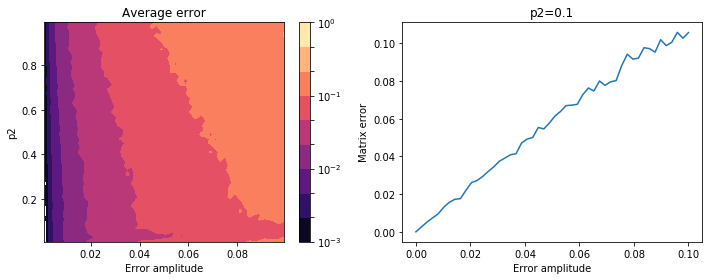

In [122]:
# Parameters
LowThres = 1e-3
HighThres = 1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_p1]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude")
plt.ylabel("p2")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = errores[:,5]
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude")
plt.ylabel("Matrix error")
plt.title("p2=0.1")

plt.tight_layout()



**Ellipticity**

El resultado es un plot 2D con amplitud de error y la elipticidad como ejes x e y.

In [3]:
tic = time.time()
# Espacio de medida
Nerrores = 50
Nelip = 50
Naverage = 200
max_angulo = 180
max_error = 5
max_elip = 45
# Otros parametros
p1 = 0.95
p2 = 0.1
# Crear variables
chi_array = np.linspace(0,max_elip,Nelip)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Nelip])

# Bucle principal
for indC, chi in enumerate(chi_array):
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            # Crear matriz con angulo aleatorio            
            angulo = np.random.rand(1) * max_angulo * degrees
            M = ps.general_diattenuator_parvect(p1, p2, angulo, chi*degrees, carac=False)
            # Crear la matriz con error
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            chi_final = (chi + noise)*degrees
            M_con_error = ps.general_diattenuator_parvect(p1, p2, angulo, chi_final, carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indC] = 1e-10
        else:
            errores[indE, indC] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))

Elapsed time is: 217.869000196


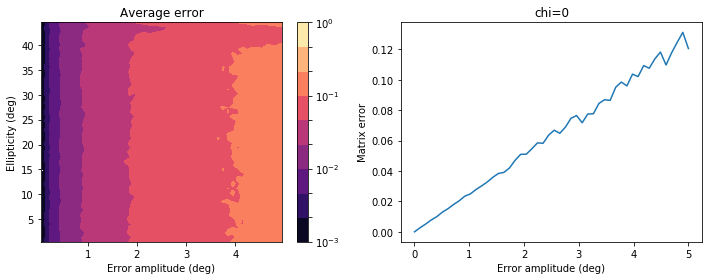

In [5]:
# Parameters
LowThres = 1e-3
HighThres = 1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_elip]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Ellipticity (deg)")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = errores[:,0]
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Matrix error")
plt.title("chi=0")

plt.tight_layout()

**Delay**

Normalmente no consideramos delay en un polarizador, pero durante la calibración vimos que es necesario considerarlo. Así que vamos a hacerlo. El resultado es un plot 2D con amplitud de error y delay como ejes x e y.

In [5]:
tic = time.time()
# Espacio de medida
Nerrores = 31
Ndelay = 29
Naverage = 100
max_angulo = 180
max_error = 5
max_delay = 175
# Otros parametros
p1 = 0.95
p2 = 0.1
chi = 0
# Crear variables
delay_array = np.linspace(5,max_delay,Ndelay)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Ndelay])

# Bucle principal
for indD, delay in enumerate(delay_array):
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            # Crear matriz con angulo aleatorio            
            angulo = np.random.rand(1) * max_angulo * degrees            
            M = ps.general_diattenuator_retarder_parvect(
                p1, p2, angulo, chi, delay*degrees, carac=False)
            # Crear la matriz con error
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            delay_final = (delay + noise)*degrees
            M_con_error = ps.general_diattenuator_retarder_parvect(
                p1, p2, angulo, chi, delay_final[0], carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indD] = 1e-10
        else:
            errores[indE, indD] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))


Elapsed time is: 514.756999969


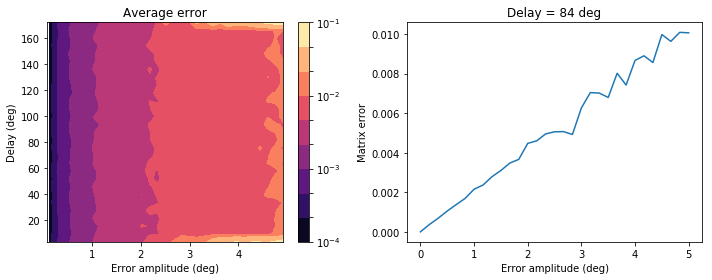

In [6]:
# Parameters
LowThres = 1e-4
HighThres = 0.1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_delay]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Delay (deg)")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = errores[:,14]
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Matrix error")
plt.title("Delay = 84 deg")

plt.tight_layout()



## Retardador

Ahora vamos con el retardador. Aquí hay que testear cuatro parámetros: ángulo, p1=p2, desfase y elipticidad. Los valores por defecto serán: p1=p2 = 0.98, desfase = 90º, chi = 0.

**Ángulo**

En este caso no voy a promediar con diferentes ángulos. El resultado es un plot 2D con amplitud de error y ángulo como ejes x e y.

In [134]:
tic = time.time()
# Espacio de medida
Nerrores = 30
Nangulos = 30
Naverage = 100
max_angulo = 180
max_error = 5
# Otros parametros
p1 = 0.98
delta = 90*degrees
chi = 0
# Crear variables
fi = np.linspace(0,max_angulo,Nangulos)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Nangulos])

# Bucle principal
for indA, angulo in enumerate(fi):
    M = ps.general_diattenuator_retarder_parvect(
        p1, p1, angulo*degrees, chi, delta, carac=False)
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            angulo_final = (angulo + noise)*degrees
            M_con_error = ps.general_diattenuator_retarder_parvect(
                p1, p1, angulo_final, chi, delta, carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #print(medida[indM])
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indA] = 1e-10
        else:
            errores[indE, indA] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))


Elapsed time is: 255.444999933


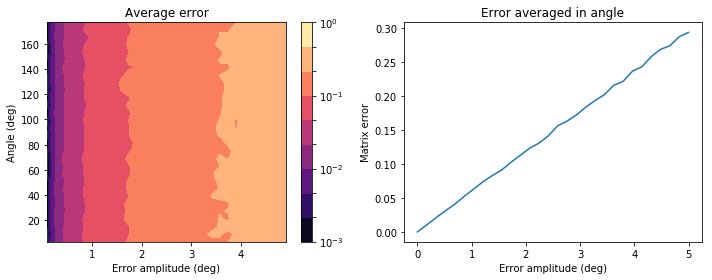

In [136]:
# Parameters
LowThres = 1e-3
HighThres = 1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_angulo]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Angle (deg)")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = np.mean(errores, axis = 1)
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Matrix error")
plt.title("Error averaged in angle")

plt.tight_layout()



**p1**

El resultado es un plot 2D con amplitud de error y p1=p2 como ejes x e y.

In [143]:
tic = time.time()
# Espacio de medida
Nerrores = 30
Np1 = 30
Naverage = 100
max_angulo = 180
max_error = 0.1
max_p1 = 1
# Otros parametros
chi = 0
delta = 90*degrees
# Crear variables
p1_array = np.linspace(0,max_p1,Np1)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Np1])

# Bucle principal
for indP, p1 in enumerate(p1_array):
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            # Crear matriz con angulo aleatorio            
            angulo = np.random.rand(1) * max_angulo * degrees            
            M = ps.general_diattenuator_retarder_parvect(
                p1, p1, angulo, chi, delta, carac=False)
            # Crear la matriz con error
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            p1_final = (p1 + noise)
            if p1_final<0.001:
                p1_final = [0.001]
            M_con_error = ps.general_diattenuator_retarder_parvect(
                p1_final[0], p1_final[0], angulo, chi, delta, carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indP] = 1e-10
        else:
            errores[indE, indP] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))


Elapsed time is: 597.719000101


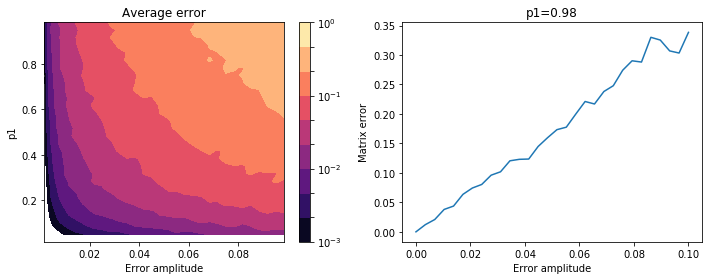

In [144]:
# Parameters
LowThres = 1e-3
HighThres = 1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_p1]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude")
plt.ylabel("p1")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = errores[:,-2]
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude")
plt.ylabel("Matrix error")
plt.title("p1=0.98")

plt.tight_layout()



**Delay**

El resultado es un plot 2D con amplitud de error y delay como ejes x e y.

In [7]:
tic = time.time()
# Espacio de medida
Nerrores = 31
Ndelay = 29
Naverage = 100
max_angulo = 180
max_error = 5
max_delay = 175
# Otros parametros
p1 = 0.98
chi = 0
# Crear variables
delay_array = np.linspace(5,max_delay,Ndelay)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Ndelay])

# Bucle principal
for indD, delay in enumerate(delay_array):
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            # Crear matriz con angulo aleatorio            
            angulo = np.random.rand(1) * max_angulo * degrees            
            M = ps.general_diattenuator_retarder_parvect(
                p1, p1, angulo, chi, delay*degrees, carac=False)
            # Crear la matriz con error
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            delay_final = (delay + noise)*degrees
            M_con_error = ps.general_diattenuator_retarder_parvect(
                p1, p1, angulo, chi, delay_final[0], carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indD] = 1e-10
        else:
            errores[indE, indD] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))


Elapsed time is: 506.739000082


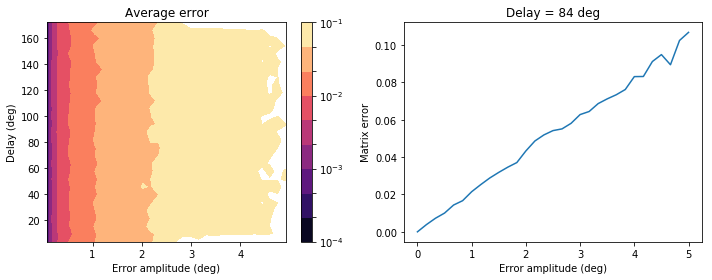

In [8]:
# Parameters
LowThres = 1e-4
HighThres = 0.1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_delay]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Delay (deg)")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = errores[:,14]
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Matrix error")
plt.title("Delay = 84 deg")

plt.tight_layout()



**Elipticidad**

El resultado es un plot 2D con amplitud de error y elipticidad como ejes x e y.

In [9]:
tic = time.time()
# Espacio de medida
Nerrores = 31
Nchi = 31
Naverage = 100
max_angulo = 180
max_error = 5
max_chi = 45
# Otros parametros
p1 = 0.98
delay = 90*degrees
# Crear variables
chi_array = np.linspace(5,max_chi,Nchi)
amplitud_error = np.linspace(0,max_error,Nerrores)
errores = np.zeros([Nerrores, Nchi])

# Bucle principal
for indC, chi in enumerate(delay_array):
    #print(M)
    for indE, error in enumerate(amplitud_error):
        medida = np.zeros(Naverage)
        # Realizar el experimento N veces para promediar
        for indM in range(Naverage):
            # Crear matriz con angulo aleatorio            
            angulo = np.random.rand(1) * max_angulo * degrees            
            M = ps.general_diattenuator_retarder_parvect(
                p1, p1, angulo, chi*degrees, delay, carac=False)
            # Crear la matriz con error
            noise = np.sign(np.random.rand(1)-0.5) * error * sqrt(np.log(np.random.rand(1)**(-1)))
            chi_final = (chi + noise)*degrees
            M_con_error = ps.general_diattenuator_retarder_parvect(
                p1, p1, angulo, chi_final[0], delay, carac=False)
            dM = M - M_con_error
            medida[indM] = np.linalg.norm(dM, ord='fro')
            #if angulo > 0:
                #print(M_con_error)
                #print(angulo_final/degrees)
        value = np.mean(medida)
        if value == 0:
            errores[indE, indC] = 1e-10
        else:
            errores[indE, indC] = np.mean(medida)
        #print('Error final con amp. error = {} y angulo = {}º: {}.'.format(
            #error, angulo, errores[indE, indA]))
toc = time.time()
print('Elapsed time is: {}'.format(toc-tic))


Elapsed time is: 492.619999886


C:\Users\Jesus\Anaconda2\lib\site-packages\matplotlib\contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


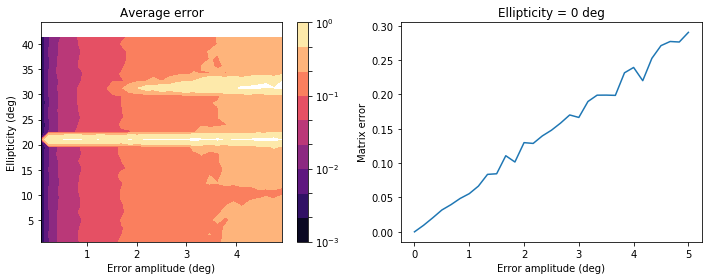

In [10]:
# Parameters
LowThres = 1e-3
HighThres = 1
Nlevels = 3

# Create levels
lev_min = np.floor(np.log10(LowThres))
lev_max = np.ceil(np.log10(HighThres))
Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
levs = np.logspace(lev_min, lev_max, Nlevels)
# Other operations
extension = [0, max_error, 0, max_chi]
errores_plot2D = np.matrix(np.array(errores)).T
# Plot
#plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
IDimage = plt.contourf(
        errores_plot2D,
        levels = levs,
        norm=colors.LogNorm(),
        origin='lower',
        extent=extension
)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Ellipticity (deg)")
plt.title("Average error")
plt.colorbar()
IDimage.set_cmap("magma")

plt.subplot(1,2,2)
errores_plot1D = errores[:,0]
#errores_plot1D = errores_plot1D[0]
plt.plot(amplitud_error, errores_plot1D)
plt.xlabel("Error amplitude (deg)")
plt.ylabel("Matrix error")
plt.title("Ellipticity = 0 deg")

plt.tight_layout()



In [167]:
print(delay_array)

[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180.]
